In [117]:
# Importing necessary libraries & modules; checking system compatibility

import sys, pip, numpy as np, pandas as pd, matplotlib.pyplot as plt
print(sys.executable)
print(sys.version)
print(pip.__version__)
print(np.__version__, pd.__version__)

/Users/jonaskorganas/coding_projects/streaming_analysis/.venv/bin/python
3.14.2 (main, Dec  5 2025, 16:49:16) [Clang 17.0.0 (clang-1700.4.4.1)]
25.3
2.3.5 2.3.3


In [118]:
# Loading Amazon Prime csv dataset & displaying first few entries for understanding structure & content

amazon_ds_path = '/Users/jonaskorganas/coding_projects/streaming_analysis/amazon_prime_titles.csv'
amazon_df = pd.read_csv(amazon_ds_path)
print(amazon_df.head(), '\n')
print(amazon_df.info())

  show_id   type                 title        director  \
0      s1  Movie   The Grand Seduction    Don McKellar   
1      s2  Movie  Take Care Good Night    Girish Joshi   
2      s3  Movie  Secrets of Deception     Josh Webber   
3      s4  Movie    Pink: Staying True  Sonia Anderson   
4      s5  Movie         Monster Maker    Giles Foster   

                                                cast         country  \
0     Brendan Gleeson, Taylor Kitsch, Gordon Pinsent          Canada   
1   Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar           India   
2  Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...   United States   
3  Interviews with: Pink, Adele, Beyoncé, Britney...   United States   
4  Harry Dean Stanton, Kieran O'Brien, George Cos...  United Kingdom   

       date_added  release_year rating duration                listed_in  \
0  March 30, 2021          2014    NaN  113 min            Comedy, Drama   
1  March 30, 2021          2018    13+  110 min     Drama, Interna

In [119]:
media_types = amazon_df.type.unique()
print("Media types in amazon prime dataset:", media_types)

Media types in amazon prime dataset: ['Movie' 'TV Show']


In [120]:
amazon_df.listed_in.head()

0              Comedy, Drama
1       Drama, International
2    Action, Drama, Suspense
3                Documentary
4             Drama, Fantasy
Name: listed_in, dtype: object

In [121]:
unique_genre_types = amazon_df.listed_in.unique()
print("Media types in amazon prime dataset: \n", unique_genre_types)

Media types in amazon prime dataset: 
 ['Comedy, Drama' 'Drama, International' 'Action, Drama, Suspense'
 'Documentary' 'Drama, Fantasy' 'Fantasy, Kids'
 'Documentary, Special Interest' 'Comedy'
 'Action, Science Fiction, Suspense' 'Drama' 'Adventure, Kids'
 'Horror, Suspense' 'Documentary, Sports' 'Horror, Science Fiction'
 'Kids, Special Interest' 'Comedy, Talk Show and Variety'
 'Science Fiction' 'Kids' 'Action, Anime, Comedy'
 'Arts, Entertainment, and Culture, Comedy, Drama' 'TV Shows'
 'Animation, Anime, Fantasy' 'Action, Adventure, Animation' 'Anime, Kids'
 'Music Videos and Concerts' 'Drama, Suspense' 'Fitness, Special Interest'
 'Faith and Spirituality, Special Interest' 'Special Interest' 'Fitness'
 'Action, Military and War, Western'
 'Arts, Entertainment, and Culture, Comedy, Talk Show and Variety'
 'Action, Western' 'Documentary, Science Fiction'
 'Adventure, Animation, Kids' 'Fantasy, Science Fiction, Suspense'
 'Suspense' 'Action' 'Documentary, LGBTQ' 'Drama, Romance, Su

In [ ]:
# Data cleaning function for Amazon Prime dataset for easier exploration & manipulation

def clean_amazon_df(df_raw):
    import pandas as pd
    
    df = df_raw.copy()
    
    # Standardize column names (if needed)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    # now columns are like 'show_id', 'type', 'title', 'director', ...
    
    # Split multi-value string columns into lists
    for col in ["cast", "country"]:             #, "listed_in"]:
        df[col] = df[col].fillna("").apply(
            lambda s: [x.strip() for x in s.split(",")] if s else []
        )

    ### Special splitting for 'listed_in', protecting "Arts, Entertainment, and Culture" as a single & outlying genre
    SPECIAL_GENRE = "Arts, Entertainment, and Culture"
    PLACEHOLDER = "__ARTS_ENTERTAINMENT_AND_CULTURE__"

    def split_listed_in(s):
        if not isinstance(s, str) or not s.strip():
            return []

        # protect the composite genre by removing its commas temporarily
        s_protected = s.replace(SPECIAL_GENRE, PLACEHOLDER)

        # normal split on commas
        parts = [p.strip() for p in s_protected.split(",") if p.strip()]

        # restore the original name
        cleaned = [
            p.replace(PLACEHOLDER, SPECIAL_GENRE)
            for p in parts
        ]
        return cleaned

    df["listed_in"] = df["listed_in"].apply(split_listed_in)
    ###

    # Extract duration as numeric (for movies) or number of seasons/episodes (for TV shows)    
    def parse_minutes(x):
        if isinstance(x, str):
            s = x.strip()
            if "min" in s:
                try:
                    return int(s.split()[0])
                except ValueError:
                    return None
        return None
    
    def parse_seasons(x):
        if isinstance(x, str):
            s = x.strip()
            # handle both singular "Season" and plural "Seasons"
            if "Season" in s or "Seasons" in s:
                try:
                    return int(s.split()[0])
                except ValueError:
                    return None
        return None
    
    df["duration_mins"] = df["duration"].apply(parse_minutes)
    df["duration_seasons"] = df["duration"].apply(parse_seasons)
    df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
    df["rating"] = df["rating"].fillna("NaN")

    return df


test_df = clean_amazon_df(amazon_df)
print(test_df.head(), '\n')
print(test_df.info())

  show_id   type                 title        director  \
0      s1  Movie   The Grand Seduction    Don McKellar   
1      s2  Movie  Take Care Good Night    Girish Joshi   
2      s3  Movie  Secrets of Deception     Josh Webber   
3      s4  Movie    Pink: Staying True  Sonia Anderson   
4      s5  Movie         Monster Maker    Giles Foster   

                                                cast           country  \
0   [Brendan Gleeson, Taylor Kitsch, Gordon Pinsent]          [Canada]   
1  [Mahesh Manjrekar, Abhay Mahajan, Sachin Khede...           [India]   
2  [Tom Sizemore, Lorenzo Lamas, Robert LaSardo, ...   [United States]   
3  [Interviews with: Pink, Adele, Beyoncé, Britne...   [United States]   
4  [Harry Dean Stanton, Kieran O'Brien, George Co...  [United Kingdom]   

       date_added  release_year rating duration                  listed_in  \
0  March 30, 2021          2014    NaN  113 min            [Comedy, Drama]   
1  March 30, 2021          2018    13+  110 min   

In [140]:
test_df[
    test_df["listed_in"].apply(
        lambda g: "Arts, Entertainment, and Culture" in g
    )
][["listed_in"]].head()

,listed_in
22,"[Arts, Entertainment, and Culture, Comedy, Drama]"
53,"[Arts, Entertainment, and Culture, Comedy, Tal..."
93,"[Arts, Entertainment, and Culture, Comedy]"
94,"[Arts, Entertainment, and Culture, Comedy, Spe..."
107,"[Arts, Entertainment, and Culture]"


In [124]:
amazon_media = test_df["listed_in"]

amazon_prime_genres = []
for film in amazon_media:
    for genre in film:
        if genre not in amazon_prime_genres:
            amazon_prime_genres.append(genre)

print(amazon_prime_genres)
print(len(amazon_prime_genres))

['Comedy', 'Drama', 'International', 'Action', 'Suspense', 'Documentary', 'Fantasy', 'Kids', 'Special Interest', 'Science Fiction', 'Adventure', 'Horror', 'Sports', 'Talk Show and Variety', 'Anime', 'Arts, Entertainment, and Culture', 'TV Shows', 'Animation', 'Music Videos and Concerts', 'Fitness', 'Faith and Spirituality', 'Military and War', 'Western', 'LGBTQ', 'Romance', 'Unscripted', 'Young Adult Audience', 'Arthouse', 'Historical']
29


In [125]:
# Movies-only DataFrame
test_movies_df = test_df[test_df["type"] == "Movie"].copy()

# TV-Shows-only DataFrame
test_tv_shows_df = test_df[test_df["type"] == "TV Show"].copy()

print("Movies:", len(test_movies_df))
print("TV Shows:", len(test_tv_shows_df))

Movies: 7814
TV Shows: 1854


In [126]:
amazon_df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

In [127]:
test_df.duration_seasons.describe()

count    1854.000000
mean        1.723301
std         1.821656
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        29.000000
Name: duration_seasons, dtype: float64

In [128]:
test_df.duration_mins.describe()

count    7814.000000
mean       91.311876
std        40.333086
min         0.000000
25%        75.000000
50%        91.000000
75%       106.000000
max       601.000000
Name: duration_mins, dtype: float64

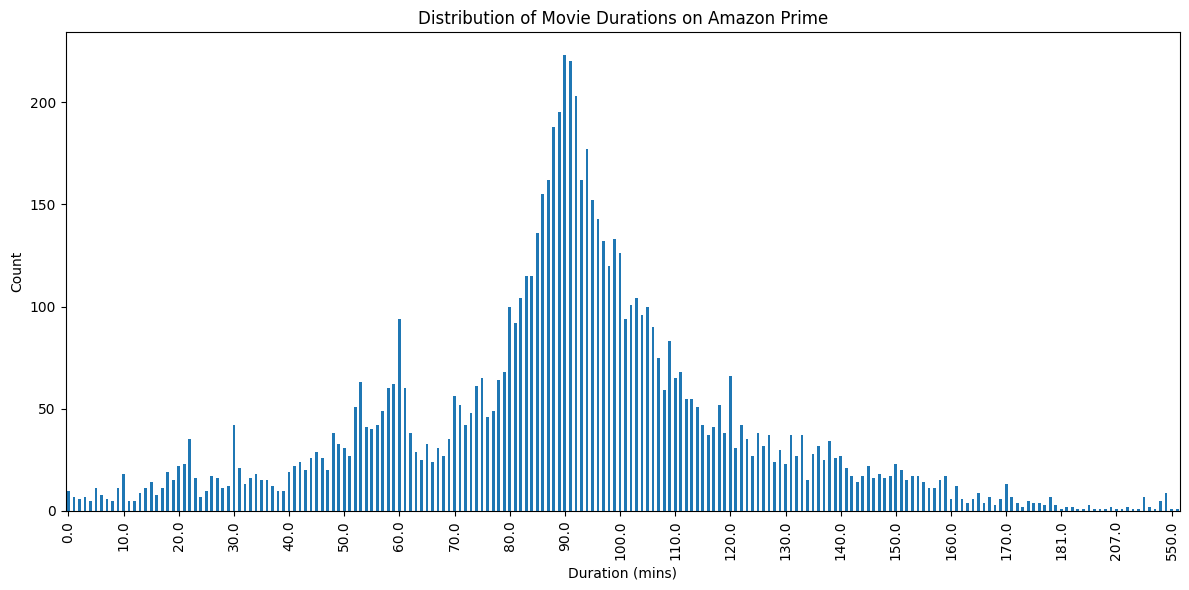

In [156]:
movies_ax = test_movies_df.groupby("duration_mins").size().plot(kind="bar", figsize=(12,6))

movies_ax.set_xticks(movies_ax.get_xticks()[::len(movies_ax.get_xticks()) // 20])
movies_ax.set_xlabel("Duration (mins)")
movies_ax.set_ylabel("Count")

plt.title("Distribution of Movie Durations on Amazon Prime")
plt.xlabel("Duration (mins)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

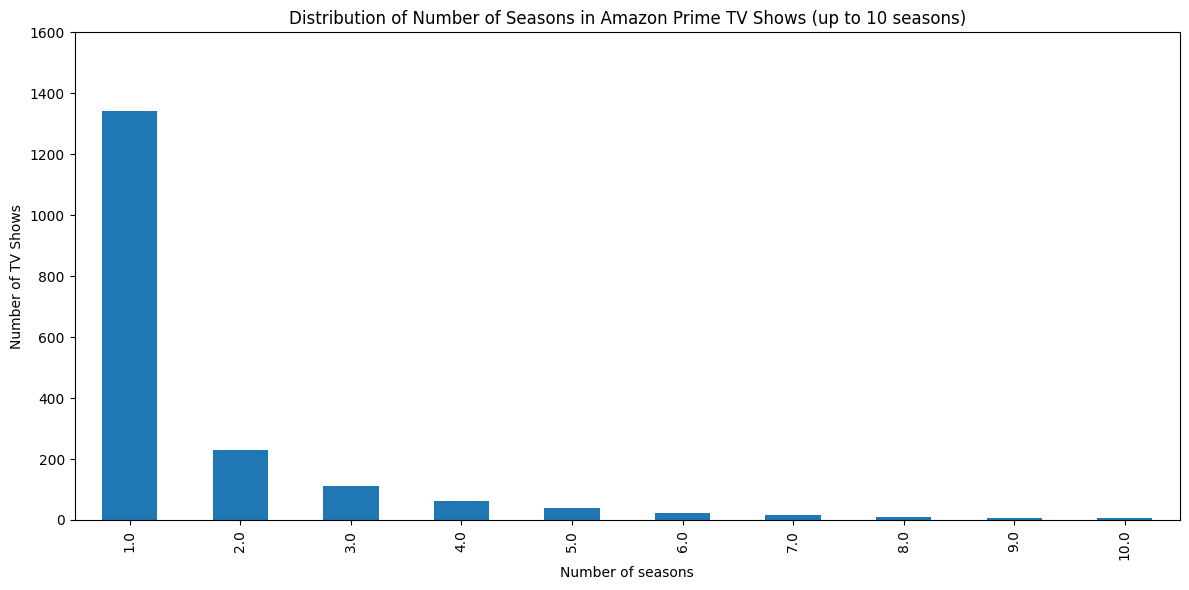

In [155]:
# Filtering for TV shows with 10 seasons or less, as few tv shows ever suceed enough tp exceed this number
filtered_tv = test_tv_shows_df[test_tv_shows_df["duration_seasons"] <= 10]

shows_ax = filtered_tv.groupby("duration_seasons").size().plot(kind="bar", figsize=(12,6))

shows_ax.set_xticks(shows_ax.get_xticks()[::len(shows_ax.get_xticks()) // 10])
shows_ax.set_yticks(shows_ax.get_yticks()[::len(shows_ax.get_yticks()) // 8])
shows_ax.set_xlabel("Number of seasons")
shows_ax.set_ylabel("Number of TV Shows")
shows_ax.set_title("Distribution of Number of Seasons in Amazon Prime TV Shows (up to 10 seasons)")
plt.tight_layout()
plt.show()

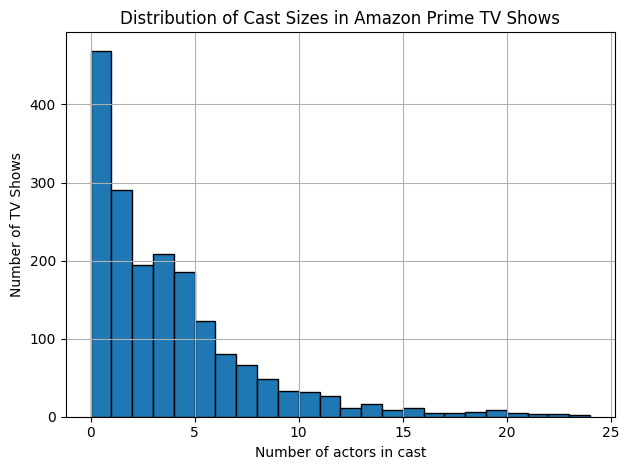

In [154]:
test_tv_shows_df["cast_count"] = test_tv_shows_df["cast"].apply(len)
test_tv_shows_df["cast_count"].hist(bins=range(0, 25), edgecolor='black')
plt.xlabel("Number of actors in cast")
plt.ylabel("Number of TV Shows")
plt.title("Distribution of Cast Sizes in Amazon Prime TV Shows")
plt.tight_layout()
plt.show()

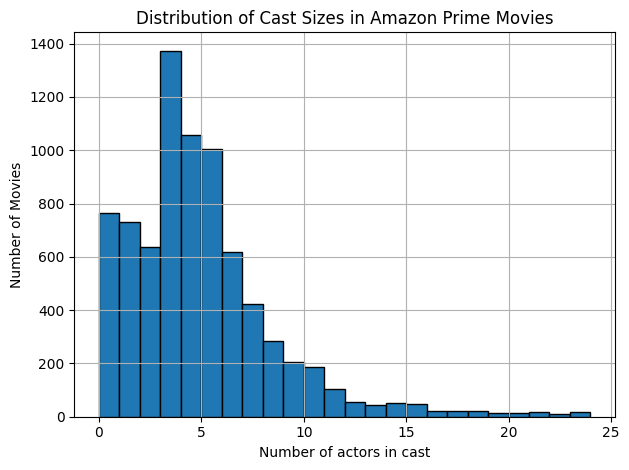

In [153]:
test_movies_df["cast_count"] = test_movies_df["cast"].apply(len)
test_movies_df["cast_count"].hist(bins=range(0, 25), edgecolor='black')
plt.xlabel("Number of actors in cast")
plt.ylabel("Number of Movies")
plt.title("Distribution of Cast Sizes in Amazon Prime Movies")
plt.tight_layout()
plt.show()

In [133]:
movies = amazon_df.type == 'Movie'
tv_shows = amazon_df.type == 'TV Show'
print("Total entries in dataset:", amazon_df.shape[0], '\n')
print("Number of movies:", movies.sum())
print("Number of TV shows:", tv_shows.sum(), '\n')
print(amazon_df[movies].listed_in.head(10))

Total entries in dataset: 9668 

Number of movies: 7814
Number of TV shows: 1854 

0                        Comedy, Drama
1                 Drama, International
2              Action, Drama, Suspense
3                          Documentary
4                       Drama, Fantasy
5                        Fantasy, Kids
6        Documentary, Special Interest
7                               Comedy
8    Action, Science Fiction, Suspense
9                                Drama
Name: listed_in, dtype: object


In [146]:
test_amazon_casts = test_df["cast"]

# Extract unique cast members from the Amazon Prime dataset & add to a list
test_amazon_prime_cast_members = []

# Iterate through each cast entry in the dataset
for casts in test_amazon_casts:

    # Skip empty (NaN) entries
    if not casts:
        continue

    else:
        # Split multiple cast members & add unique ones to the list
        for actor in casts:
            if actor not in test_amazon_prime_cast_members:
                test_amazon_prime_cast_members.append(actor)

In [150]:
print(test_amazon_prime_cast_members[:10], '\n')
print(f'Total unique cast members on Amazon Prime: {len(test_amazon_prime_cast_members)}')

['Brendan Gleeson', 'Taylor Kitsch', 'Gordon Pinsent', 'Mahesh Manjrekar', 'Abhay Mahajan', 'Sachin Khedekar', 'Tom Sizemore', 'Lorenzo Lamas', 'Robert LaSardo', 'Richard Jones'] 

Total unique cast members on Amazon Prime: 31849


In [137]:
# explode genres into separate rows
df_exploded = test_df.explode("listed_in")

# cast is already a list after cleaning
df_exploded["cast_count"] = df_exploded["cast"].apply(len)

genre_cast_counts = df_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
print(genre_cast_counts)

listed_in
Drama                               21088
Comedy                              11184
Action                               9034
Suspense                             8646
Horror                               4285
Romance                              3721
Kids                                 3055
Documentary                          2664
Science Fiction                      2565
Special Interest                     2147
International                        1924
Arts, Entertainment, and Culture     1656
Adventure                            1620
Western                              1573
Animation                            1115
TV Shows                              741
Arthouse                              700
Sports                                668
LGBTQ                                 614
Young Adult Audience                  536
Unscripted                            433
Fantasy                               408
Military and War                      350
Faith and Spirituality  

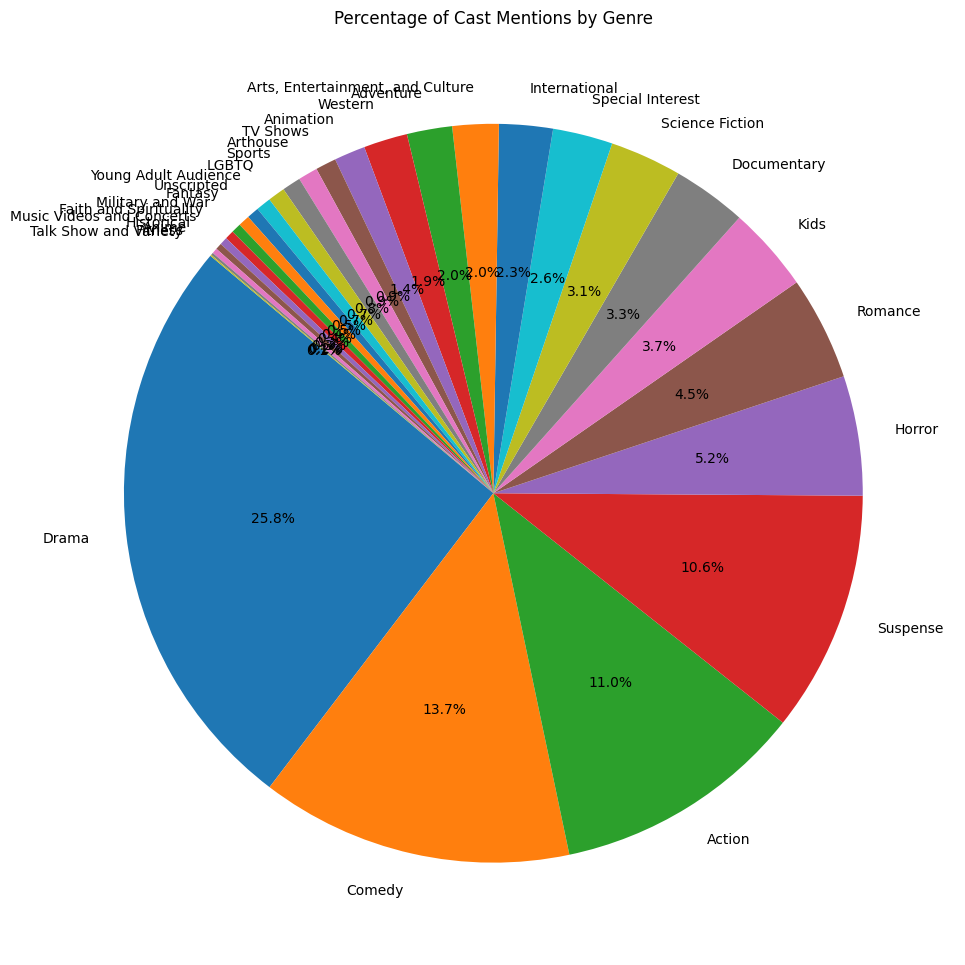

In [ ]:
# Still to be cleaned up & formatted correctly in desired style & presented information
genre_cast_counts = genre_cast_counts.sort_values(ascending=False)

plt.figure(figsize=(10,10))
plt.pie(
    genre_cast_counts,
    labels=genre_cast_counts.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Percentage of Cast Mentions by Genre")
plt.tight_layout()
plt.show()

In [139]:
print("Genre counts in Amazon Prime media dataset: \n")
for genre in amazon_prime_genres:
    genre_count = 0
    for film in amazon_media:
        if genre in film:
            genre_count += 1
    print(f"{genre}: {genre_count}")

Genre counts in Amazon Prime media dataset: 

Comedy: 2099
Drama: 3687
International: 355
Action: 1657
Suspense: 1501
Documentary: 993
Fantasy: 68
Kids: 1085
Special Interest: 980
Science Fiction: 457
Adventure: 259
Horror: 875
Sports: 160
Talk Show and Variety: 14
Anime: 80
Arts: 483
Entertainment: 483
and Culture: 483
TV Shows: 263
Animation: 547
Music Videos and Concerts: 155
Fitness: 83
Faith and Spirituality: 66
Military and War: 44
Western: 234
LGBTQ: 113
Romance: 674
Unscripted: 152
Young Adult Audience: 87
Arthouse: 141
Historical: 31
